## Predicting Airline Passenger Satisfaction

by Group 12
2024/11/20

In [6]:
import numpy as np
import pandas as pd


## Summary
This project analyzes the factors influencing customer satisfaction for an airline, using a classification model built on data that includes various passenger features. The goal is to identify which attributes (such as flight-related, service quality, and demographics) contribute most significantly to passenger satisfaction. For the model, we used the k-nearest neighbors (k-NN) algorithm to classify passengers into satisfied or unsatisfied categories. 

## Methods

### Data
The dataset contains a variety of features from passengers’ flight experiences, including:

- **Demographic data** (e.g., age, gender)
- **Flight details** (e.g., flight distance, time of day)
- **Service-related features** (e.g., quality of meal, seat comfort, check-in process)

The data was pre-processed by:

- Handling missing values
- Normalizing numerical features
- Splitting the data into training and test sets (70% training, 30% test)
  
This data was sourced from Kaggle and can be found from [here](https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction?select=train.csv).

### Model
We used the **k-nearest neighbors (k-NN)** algorithm to predict satisfaction, employing 5-fold cross-validation to tune hyperparameters. 

### Evaluation Metric
The evaluation metric for the model was the **F2 score**, with a beta value of 2 to weigh recall higher than precision, which is critical in ensuring that all unsatisfied passengers are correctly identified.


## EDA
For an exploratory data analysis (EDA) on the Airline Passenger Satisfaction dataset, the goal is to better understand the structure of the dataset, identify potential issues (such as missing values, outliers, etc.), and uncover initial insights about the factors that might influence passenger satisfaction.


### Understanding the Dataset
- First, we need to load the dataset and check the basic structure.
- We will check the number of rows and columns, data types of each feature, and get a basic sense of how the data is organized.

In [12]:
# Load the dataset
data = pd.read_csv('../data/train.csv')

# Basic overview of the dataset
print(data.info())
# print(data.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

### Missing Values and Data Quality
- Identify if there are any missing or null values in the dataset.
- Check for duplicates or any irrelevant columns that do not add value to the analysis.

In [15]:
# Check for missing values
print(data.isnull().sum())

Unnamed: 0                             0
id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction    

In [14]:
# Check for duplicates
print(data.duplicated().sum())

0


### Data Types and Features
- Analyze the data types (e.g., categorical, numerical, datetime) of each column.
- For categorical features, check the number of unique values.
- For numerical features, check their ranges, distributions, and potential outliers.

In [29]:
# Check data types and unique values
print(data.dtypes)

Unnamed: 0                             int64
id                                     int64
Gender                                object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure 

In [18]:
print(data.nunique())

Unnamed: 0                           103904
id                                   103904
Gender                                    2
Customer Type                             2
Age                                      75
Type of Travel                            2
Class                                     3
Flight Distance                        3802
Inflight wifi service                     6
Departure/Arrival time convenient         6
Ease of Online booking                    6
Gate location                             6
Food and drink                            6
Online boarding                           6
Seat comfort                              6
Inflight entertainment                    6
On-board service                          6
Leg room service                          6
Baggage handling                          5
Checkin service                           6
Inflight service                          6
Cleanliness                               6
Departure Delay in Minutes      

### Distribution of Numerical Variables
Plot histograms or boxplots for all numerical features to check their distribution and identify any outliers.

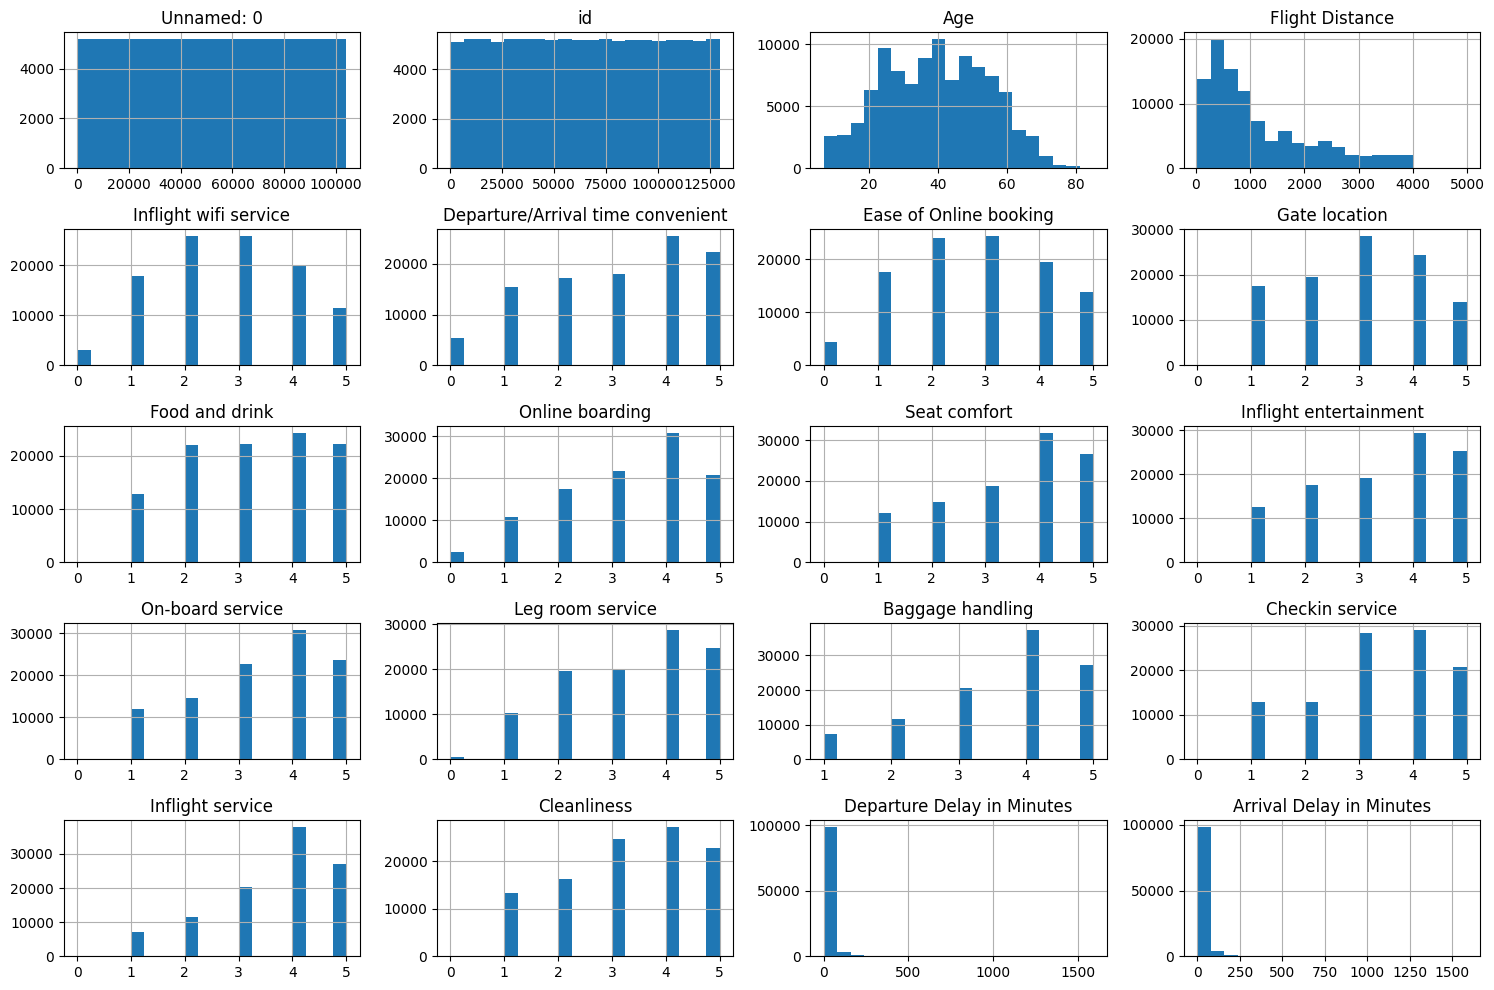

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograms for numerical features
data.hist(bins=20, figsize=(15, 10))
plt.tight_layout()
plt.show()

# Boxplots for numerical features
#numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
#for col in numerical_cols:
#    plt.figure(figsize=(8, 4))
#    sns.boxplot(x=data[col])
#    plt.title(f'Boxplot of {col}')
#    plt.show()


### Correlation Between Features
- Check how numerical features correlate with each other, and see if there are any strong correlations. This can be done using a correlation matrix and visualized with a heatmap.

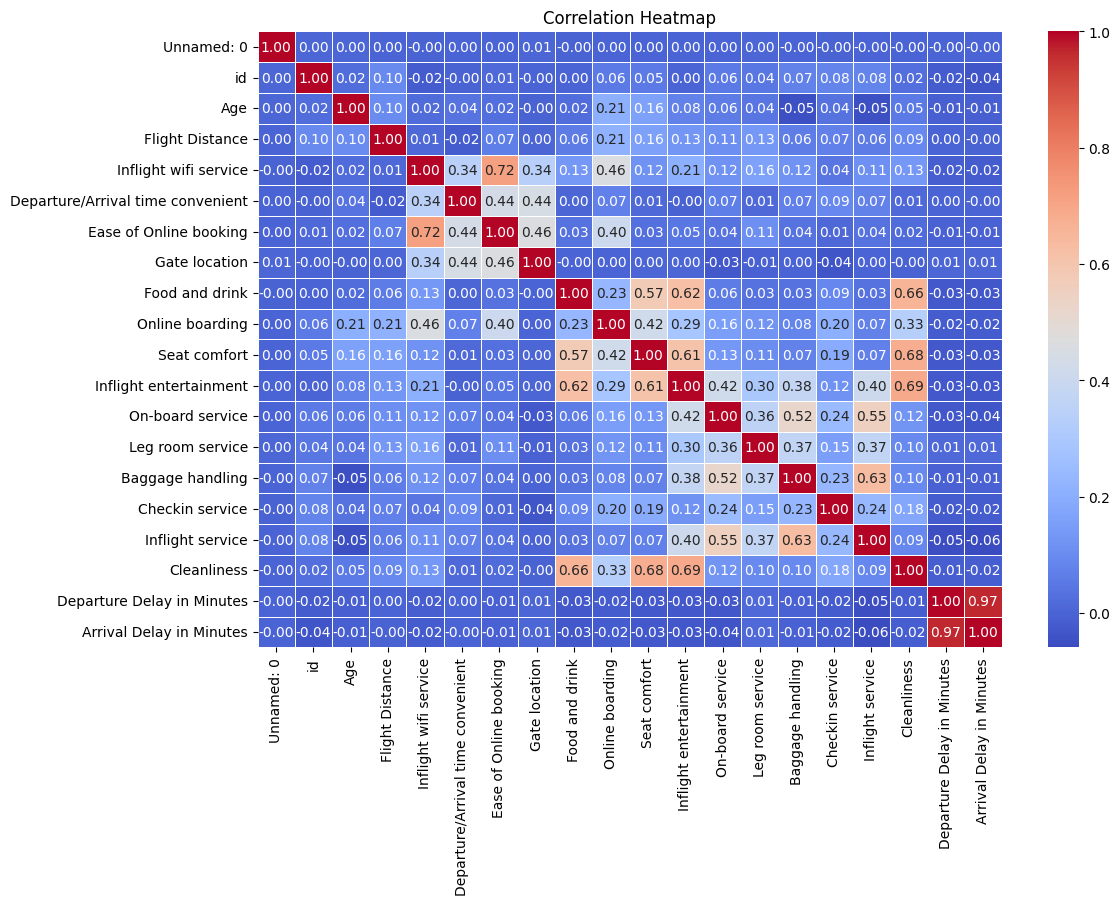

In [24]:
# Correlation matrix
numeric_data = data.select_dtypes(include=['number'])
correlation_matrix = numeric_data.corr()

# Heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


## Preprocessing Steps for the Airline Passenger Satisfaction Dataset

### 1. Handle Missing Values
From the Exploratory Data Analysis (EDA), we identified missing values in certain columns. We can handle them as follows:

- **Impute missing values in numerical columns** with the **median** or **mean**.
- **Impute missing values in categorical columns** with the **most frequent value** (mode).

### 2. Encoding Categorical Variables
Categorical columns like Gender, Type of Travel, Class, Satisfaction, and others will need to be encoded:

- **Satisfaction** will be encoded as a binary variable (`0` for "Dissatisfied", `1` for "Satisfied").
- Other categorical variables will be encoded using **one-hot encoding**, where applicable.

### 3. Feature Engineering
- **Age Group**: Based on the distribution of ages, we created **age bins**, which will be encoded using **one-hot encoding**.
- **Distance Group**: We might categorize the **Flight Distance** into bins (e.g., short, medium, long) for better interpretability.

### 4. Scaling Numerical Features
We need to **standardize** or **scale** numerical features like Age, Flight Distance, Seat Comfort, Inflight Wifi Service, etc., so that they all have similar scales. This will help avoid dominance of variables with larger ranges.


In [35]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import category_encoders as ce



categorical_cols = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 
                    'Inflight wifi service', 'Departure/Arrival time convenient', 
                    'Ease of Online booking', 'Gate location', 'Food and drink', 
                    'Online boarding', 'Seat comfort', 'Inflight entertainment', 
                    'On-board service', 'Leg room service', 'Baggage handling', 
                    'Checkin service', 'Inflight service', 'Cleanliness']


numerical_cols = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 
                  'Arrival Delay in Minutes']

# Define the target column (Satisfaction)
target_column = 'satisfaction'

# Create the preprocessing pipeline for features and target variable
preprocessor = make_column_transformer(
    
    (Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  
        ('encoder', OneHotEncoder(handle_unknown='ignore'))  
    ]), categorical_cols),
    
    
    (Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')), 
        ('scaler', StandardScaler()) 
    ]), numerical_cols)
)

# Apply BinaryEncoder to the target column 'satisfaction' 
target_encoder = ce.BinaryEncoder(cols=[target_column])

# Now prepare X (features) and y (target) by preprocessing them
X_train = data.drop([target_column, 'Unnamed: 0', 'id'], axis=1)  
y_train = data[[target_column]]  


preprocessor


ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Gender', 'Customer Type', 'Type of Travel',
                                  'Class', 'Inflight wifi service',
                                  'Departure/Arrival time convenient',
                                  'Ease of Online booking', 'Gate location',
                                  'Food and drink', 'Online boarding',
                                  'Seat comfort', 'Inflight entertainment',
                                  'On-board service', 'Leg room service',
                                  'Baggage handling', 'Checkin service',
                                  'Inflight service', 'Cleanliness']),
                                ('pipeline-2',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'Flight Distance',
                                  'Departure Delay in Minutes',
                                  'Arrival Delay in Minutes'])])